In [117]:
!pip install matplotlib
!pip install pymysql sqlalchemy
!pip install mysql-connector-python python-dotenv
!pip install sqlalchemy mysql-connector-python


In [118]:
import os
import matplotlib.pyplot as plt

from dotenv import load_dotenv

class Config:
    def __init__(self):
        load_dotenv()
        self.tidb_host = os.getenv("TIDB_HOST", "gateway01.us-east-1.prod.aws.tidbcloud.com")
        self.tidb_port = int(os.getenv("TIDB_PORT", "4000"))
        self.tidb_user = os.getenv("TIDB_USER", "EcFsmzHzn16sz32.root")
        self.tidb_password = os.getenv("TIDB_PASSWORD", "4UTXzVBKxU10w2Z1")
       # self.tidb_db_name = os.getenv("TIDB_DB_NAME", "embracepath")
        self.tidb_db_name = "embracepath"
        self.ca_path = os.getenv("CA_PATH", "")

In [119]:
class LuTypeTable:
    def __init__(self, TypeID, TypeName, TypeNameVector, Description, DescriptionVector, create_by, create_dt, modified_by, modified_dt, active_flg):
        self.TypeID = TypeID
        self.TypeName = TypeName
        self.TypeNameVector = TypeNameVector
        self.Description = Description
        self.DescriptionVector = DescriptionVector
        self.create_by = create_by
        self.create_dt = create_dt
        self.modified_by = modified_by
        self.modified_dt = modified_dt
        self.active_flg = active_flg

    def to_dict(self):
        return {
            'TypeID': self.TypeID,
            'TypeName': self.TypeName,
            'TypeNameVector': self.TypeNameVector,
            'Description': self.Description,
            'DescriptionVector': self.DescriptionVector,
            'create_by': self.create_by,
            'create_dt': self.create_dt,
            'modified_by': self.modified_by,
            'modified_dt': self.modified_dt,
            'active_flg': self.active_flg
        }

In [120]:
from sqlalchemy import create_engine
import pandas as pd
import logging

class DatabaseService:
    def __init__(self, config):
        self.config = config
        logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(levelname)s - %(message)s')
        self.engine = self.create_engine()

    def create_engine(self):
        # Construct the database URL
        database_url = f"mysql+mysqlconnector://{self.config.tidb_user}:{self.config.tidb_password}@{self.config.tidb_host}:{self.config.tidb_port}/{self.config.tidb_db_name}"
        if self.config.ca_path:
            connect_args = {
                'ssl_ca': self.config.ca_path,
                'ssl_verify_cert': True,
                'ssl_verify_identity': True
            }
            return create_engine(database_url, connect_args=connect_args)
        return create_engine(database_url)

    def fetch_data(self, query: str, params=None):
        try:
            if params:
             #   print("Params Type:", {type(p) for p in params})
             #   print("Params Value:", params)
             #   print("with params")
             #   print("query is :", query)
                df = pd.read_sql(query, self.engine, params=params)
                return df
            else:
           #     print("without params")
                return pd.read_sql(query, self.engine)
        except Exception as e:
            logging.error("Failed to fetch data: %s", e)
            return pd.DataFrame()  # Return an empty DataFrame on failure

    def get_reward(self, user_id: int, exercise_id: int, emotion_id: int) -> float:
        user_id=1 # will need to remove once data is in user_exercise_feedback
        exercise_id=2956 # willl need to remove once data is in user_exercise_feedback
        emotion_id = 3 # willl need to remove once data is in user_exercise_feedback
        #print("in get_reward")
        query = """
        SELECT feedback FROM user_exercise_feedback 
        WHERE user_id = %s AND exercise_id = %s AND emotion_id = %s
        """
        feedback_df = self.fetch_data(query, params=(user_id, exercise_id, emotion_id))
        #print("feedback_df is ", feedback_df.head)
        if not feedback_df.empty:
            return feedback_df['feedback'].iloc[0] / 5.0
        else:
            return 0.0  # Return a default value when no feedback is available

    def fetch_num_exercises(self):
        query = "SELECT COUNT(*) FROM recommended_exercise WHERE active_flg = TRUE"
        df = self.fetch_data(query)
        if not df.empty:
            return df.iloc[0, 0]
        return 0

    def fetch_recommended_exercises(self):
        query = """
        SELECT recommended_exercise_id, exercise_id, initial_q_value
        FROM recommended_exercise
        WHERE active_flg = TRUE
        """
        return self.fetch_data(query)

    def get_emotion_vector_by_typename(self, typeName: str):
        query = """
        SELECT TypeID, TypeName, TypeNameVector, Description, DescriptionVector,
        create_by, create_dt, modified_by, modified_dt, active_flg
        FROM lu_emotion_type WHERE TypeName = %s
        """
        return self.fetch_data(query, params=(typeName,))


In [121]:
class EpsilonGreedyAgent:
    def __init__(self, epsilon, environment):
        self.epsilon = epsilon
        self.environment = environment
        self.exercises_df = environment._fetch_recommended_exercises()
        self.Q_values = np.zeros(len(self.exercises_df))  # Adjust size based on fetched data

    def select_action(self, state):
        if np.random.rand() < self.epsilon:
            # Explore: choose a random action from the available exercises
            action_idx = np.random.randint(len(self.exercises_df))
        else:
            # Exploit: choose the best known action
            action_idx = np.argmax(self.Q_values)
        action = self.exercises_df.iloc[action_idx]
        return (action['recommended_exercise_id'], action['exercise_id'], action['initial_q_value'])

    def update(self, action_idx, reward):
        # Incremental update to the Q-value for the chosen action
        self.Q_values[action_idx] += (reward - self.Q_values[action_idx]) / (self.environment.action_counts[action_idx] + 1)
        self.environment.action_counts[action_idx] += 1


In [122]:
class State:
    def __init__(self, core_emotion, user_id, emotion_vector):
        self.core_emotion = core_emotion
        self.user_id = user_id
        self.emotion_vector = emotion_vector

In [125]:
import gymnasium as gym
from gymnasium.spaces import Discrete, Box
import numpy as np

class MindfulnessBanditEnv(gym.Env):
    def __init__(self, num_features:int, db_service:DatabaseService, num_actions:int):
        self.num_features = num_features
        self.db_service = db_service
        self.action_space = Discrete(num_actions)  # 10 possible actions (mindfulness exercises)
        self.observation_space = Box(low=0, high=1, shape=(num_features,), dtype=np.float32)
        self.state = None
        self.done = False
    
    def reset(self):
        core_emotion = 1 # Happiness
        user_id = 1
        emotion_vector_df = self.db_service.get_emotion_vector_by_typename("Happiness")

        # Create an instance of LuTypeTable from the first row of the DataFrame
        emotion_vector = LuTypeTable(
            TypeID=emotion_vector_df.iloc[0]['TypeID'],
            TypeName=emotion_vector_df.iloc[0]['TypeName'],
            TypeNameVector=emotion_vector_df.iloc[0]['TypeNameVector'],
            Description=emotion_vector_df.iloc[0]['Description'],
            DescriptionVector=emotion_vector_df.iloc[0]['DescriptionVector'],
            create_by=emotion_vector_df.iloc[0]['create_by'],
            create_dt=emotion_vector_df.iloc[0]['create_dt'],
            modified_by=emotion_vector_df.iloc[0]['modified_by'],
            modified_dt=emotion_vector_df.iloc[0]['modified_dt'],
            active_flg=emotion_vector_df.iloc[0]['active_flg']
        )
        #print("emotion_vector is", emotion_vector.DescriptionVector)
      #  print("before self.state")
        self.state = State(core_emotion, user_id, emotion_vector.TypeNameVector)
        observation = np.array([self.state.core_emotion, self.state.user_id, *self.state.emotion_vector])
       # print("after self.state")
        return observation

    def step(self, action):
        # Simulate the delay between the selected mindfulness exercise and the user's rating
        rating = self.get_user_rating(action) # this will be switched out by the feedback table. TODO!!!!!
        reward = self.db_service.get_reward(self.state, action, rating)
        self.done = True
        return self.state, reward, self.done, {}

    def get_user_rating(self, action):
        # Simulate the user's rating (1-5)
        rating = np.random.randint(1, 6)
        return rating

    def close(self):
        pass

Episode 0: Action 1, Reward 0.8
Episode 1: Action 0, Reward 0.8
Episode 2: Action 1, Reward 0.8
Episode 3: Action 7, Reward 0.8
Episode 4: Action 9, Reward 0.8


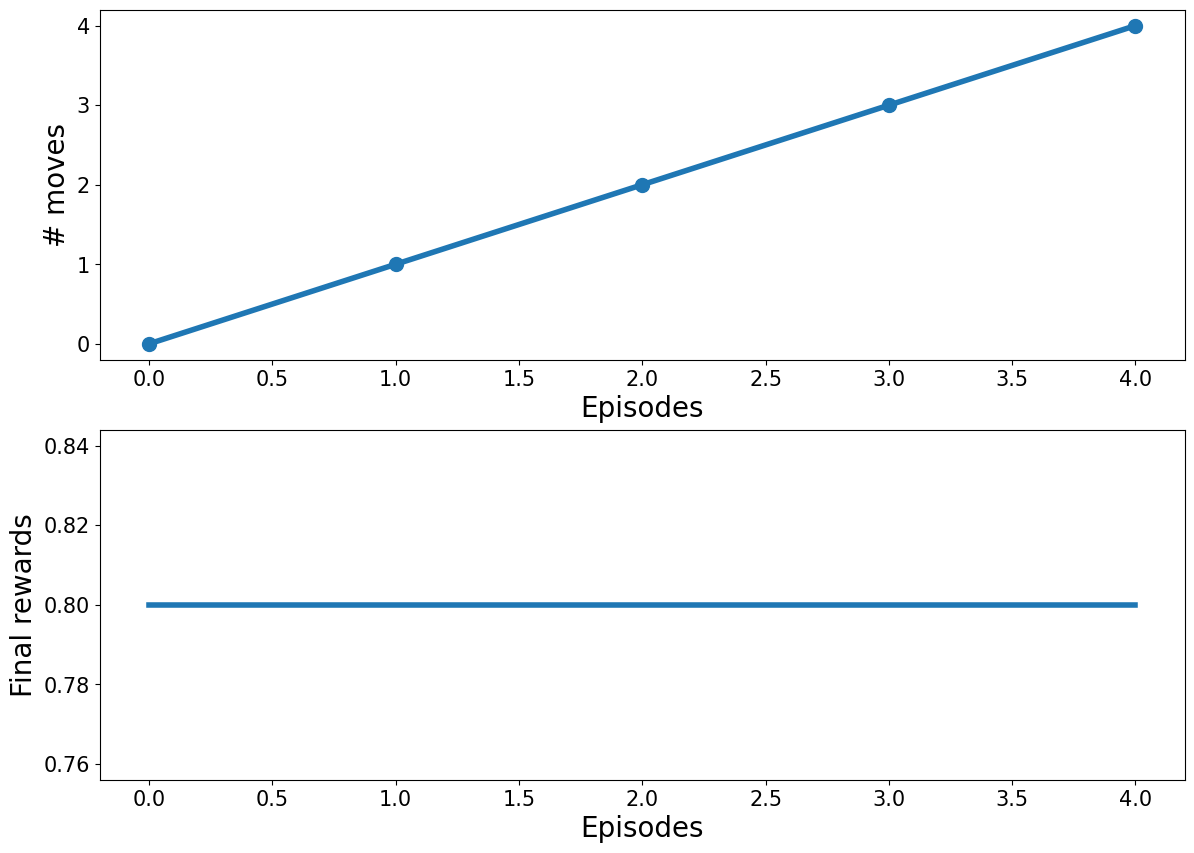

In [126]:
# Create environment and agent
# Function to plot the learning history
def plot_learning_history(history):
    fig = plt.figure(1, figsize=(14, 10))
    ax = fig.add_subplot(2, 1, 1)
    episodes = np.arange(len(history))
    moves = np.array([h[0] for h in history])
    plt.plot(episodes, moves, lw=4, marker='o', markersize=10)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Episodes', size=20)
    plt.ylabel('# moves', size=20)
    ax = fig.add_subplot(2, 1, 2)
    rewards = np.array([h[1] for h in history])
    plt.step(episodes, rewards, lw=4)
    ax.tick_params(axis='both', which='major', labelsize=15)
    plt.xlabel('Episodes', size=20)
    plt.ylabel('Final rewards', size=20)
    plt.savefig('q-learning-history.png', dpi=300)
    plt.show()
    
def main():
    config = Config()
    # https://www.meta.ai/c/a04b014a-ece0-4c51-9aa0-c51efb911727
    # for second set of eyes coding https://chatgpt.com/c/5264785b-a953-4241-b977-7a96b811d4bd
    db_service = DatabaseService(config)
    # The features are angry, sad, happy
    env = MindfulnessBanditEnv(num_features=3, db_service=db_service, num_actions=10)
    # so i need to create a custom state #     user_info = {
#         'thought_pattern': 0,  # "I'm not good enough"
#         'location': 0,  # "at home"
#         'core_emotion': 0  # "sadness"
#           'user_id': 123 $# user id
#     } this is what i will be passing in. 
    
    history = []
    for episode in range(5):  # Simulate 5 episodes
      #  print("before error")
        state = env.reset()
      #  print("after error")
        action = np.random.randint(0, 10)  # Randomly choose an action
     #   print("action is ", action)
        next_state, reward, done, _ = env.step(action)

        history.append((episode, reward))
        print(f"Episode {episode}: Action {action}, Reward {reward}")
    env.close()
    plot_learning_history(history)    
    
main()    



# def main(): 
    
#     # Define the user's thought type - this will be user current state
#     user_info = {
#         'thought_pattern': 0,  # "I'm not good enough"
#         'location': 0,  # "at home"
#         'core_emotion': 0  # "sadness"
#           'user_id': 123 $# user id
#     }
#     num_features = 3 #  number of input categories
#     num_actions = 100
#     env = MindfulnessBanditEnv(num_features, num_actions)
#     q_values = np.zeros(num_actions)
#     agent = EpsilonGreedyAgent(epsilon=0.1, environment=env)

#     history = []
#     alpha = 0.1
#     gamma = 0.9
#Failed to fetch data:Failed to fetch data:
#     for episode in range(1000):
#         state = env.reset()
#         action = agent.select_action(state)
#         print("action is", action)
#         next_state, reward, done, _ = env.step(action)
#         agent.update(action, reward, alpha, gamma)
#         history.append((action, reward))
#         if episode % 100 == 0:
#             print(f"Episo 
#de {episode}: Action {action}, Reward {reward}")

#     env.close()
#     plot_learning_history(history)

# main()    
